In [1]:
import wandb

In [2]:
import os
import random 
import math
import copy
import numpy as np
import pandas as pd

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST

import torch
from torch.nn import MSELoss
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm

In [3]:
# Autoencoder Parameters
latent_dim = 2

# Autoencoder Learning Parameters
lr = 0.001
weight_decay = 1e-3
train_test_split = 0.2

loss_fn = MSELoss()
optim_fn = Adam

# (training) number of epochs spent training
num_epochs = 10

# (training + testing) batch size
batch_size = int(256/2)

# (training + testing) image noise level
noise_factor = 1

num_display_images = 9

latent_samp_size = 0

dataset_path = 'data'
dataset = FashionMNIST

In [4]:
# os.environ['WANDB_NOTEBOOK_NAME'] = 'DAE'
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgecanedo (use `wandb login --relogin` to force relogin)


True

In [5]:

class DenoisingAutoencoder:
    def __init__(self, config, dataset, dataset_path, loss_function, optim_function):
        self.config = config
        
        self.dataset = dataset
        
        self.loss_fn = loss_function
        self.optim_fn = optim_function

        self.model_pipeline(dataset_path)
        
        
    def model_pipeline(self, dataset_path):
        with wandb.init(project='DAE', config=self.config):
            self.config = wandb.config
            
            self.make(dataset_path)
            
            ### Model Training ###
            wandb.agent(sweep_id, self.train_model(), count=5)
            self.plot_model_loss()
            
            ### Model Testing ###
            self.test_model().item()
            
            self.save_model()
            
        
    def make(self, dataset_path):
        ## Make Data
        self.load_dataset(dataset_path)
        self.visualizer()
        torch.manual_seed(0)
        
        ## Make Model
        self.encoder = self.Encoder(self.config.batch_size, encoded_space_dim=self.config.latent_dim)
        self.decoder = self.Decoder(self.config.batch_size, encoded_space_dim=self.config.latent_dim)
        
        ## Make Optimizer
        self.params_to_optimize = [ {'params': self.encoder.parameters()}, {'params': self.decoder.parameters()} ]
        self.optim = self.optim_fn(self.params_to_optimize, lr=self.config.learning_rate, weight_decay=self.config.weight_decay)
        
        ## Move Model
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(f'Processing Device: {self.device}')
        self.encoder.to(self.device)
        self.decoder.to(self.device)
            
    def save_model(self):
        self.model_encoder_path = 'models/encoder.onnx'
        self.model_decoder_path = 'models/decoder.onnx'
        
        torch.onnx.export(self.encoder, self.saved_img_batch, self.model_encoder_path, export_params=True)
        torch.onnx.export(self.decoder, self.encoded_batch, self.model_decoder_path, export_params=True)
        
        wandb.save(self.model_encoder_path)
        wandb.save(self.model_decoder_path)
            
             
    #######################
    ## Encoder Sub Class ##
    #######################
    class Encoder(nn.Module):
        def __init__(self, batch_size, encoded_space_dim):
            super().__init__()
            self.batch_size = batch_size
            self.encoder_cnn = nn.Sequential(
                nn.Conv2d(1, 8, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=0),
                nn.ReLU(True)
            )
            ## Linear Layers
            self.flatten = nn.Flatten(start_dim=1)
            self.encoder_lin = nn.Sequential(
                nn.Linear(3 * 3 * 32, self.batch_size),
                nn.ReLU(True),
                nn.Linear(self.batch_size, encoded_space_dim)
            )

        def forward(self, x):
            x = self.encoder_cnn(x)
            x = self.flatten(x)
            x = self.encoder_lin(x)
            return x
    
    #######################
    ## Decoder Sub Class ##
    #######################
    class Decoder(nn.Module):
        def __init__(self, batch_size, encoded_space_dim):
            super().__init__()
            self.batch_size = batch_size
            self.decoder_lin = nn.Sequential(
                nn.Linear(encoded_space_dim, self.batch_size),
                nn.ReLU(True),
                nn.Linear(self.batch_size, 3 * 3 * 32),
                nn.ReLU(True)
            )
            ## Linear Layers
            self.decoder_conv = nn.Sequential(
                nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
            )

        def forward(self, x):
            x = self.decoder_lin(x)
            target_shape = (-1, 32, 3, 3)
            x = x.view(target_shape)
            x = self.decoder_conv(x)
            x = torch.sigmoid(x)
            return x
    
    #####################
    ## Dataset Methods ##
    #####################
    def load_dataset(self, dataset_path):
        ## Initialize datasets
        train_dataset = self.dataset(dataset_path, train=True, download=True)
        test_dataset  = self.dataset(dataset_path, train=False, download=True)
        ## Define transformers
        train_transform = transforms.Compose( [transforms.ToTensor(),] )
        test_transform = transforms.Compose( [transforms.ToTensor(),] )
        ## Define transformed datasets
        train_dataset.transform = train_transform
        test_dataset.transform = test_transform
        ## Define train test split
        num_train = len(train_dataset)
        num_test = num_train*train_test_split
        ## Split training data
        train_data, val_data = random_split(train_dataset, [int(num_train-num_test), int(num_test)])
        ## Define data loaders
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.config.batch_size)
        valid_loader = torch.utils.data.DataLoader(val_data, batch_size=self.config.batch_size)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.config.batch_size, shuffle=True)
        ## Return
        self.train_dataset, self.test_dataset = train_dataset, test_dataset
        self.train_loader, self.valid_loader, self.test_loader = train_loader, valid_loader, test_loader

    def visualizer(self):
        data = self.train_loader.dataset[0]
        tensor = data[0]
        plt.imshow(tensor.numpy()[0], cmap='gray')
        plt.title('Sample Image Fraom Training Dataset')

    def add_noise(self, data):
        new_data = copy.deepcopy(data)
        for tensor_ind, tensor in enumerate(new_data):
            rand_tensor = noise_factor * torch.rand(tensor.shape)
            new_tensor = tensor.add(rand_tensor)
            new_data[tensor_ind] = new_tensor / torch.max(new_tensor)
        return new_data

    #############################
    ## Iterative Model Methods ##
    #############################
    def train_model(self):
        wandb.watch(self.encoder, log="all", log_freq=10)
        wandb.watch(self.decoder, log="all", log_freq=10)
        
        model_loss = {'train_loss':[], 'mse_loss': [], 'cat_loss': [], 'test_loss':[]}

        for epoch in tqdm(range(self.config.epochs)):
            train_loss, mse_loss, cat_loss = self.train_batch()
            test_loss = self.test_model()
            model_loss['train_loss'].append(train_loss)
            model_loss['test_loss'].append(test_loss)
            model_loss['mse_loss'].append(mse_loss)
            model_loss['cat_loss'].append(cat_loss)
            
            self.train_log(train_loss, mse_loss, cat_loss, test_loss, epoch)
            print(f'EPOCH {epoch + 1}/{self.config.epochs} \t train loss {train_loss} \t test loss {test_loss}')
            self.plot_sample_batch()

        self.model_loss = model_loss
    
    def train_batch(self):
        self.encoder.train()
        self.decoder.train()
        losses, mse_losses, cat_losses = [], [], []
        
        for image_batch, _ in self.train_loader:
            noisy_batch = self.add_noise(image_batch)
            noisy_batch = noisy_batch.to(self.device)    
            
            encoded_batch = self.encoder(noisy_batch)
            decoded_batch = self.decoder(encoded_batch)
            
            conc_out, conc_label = decoded_batch.cpu(), image_batch.cpu()
            
            loss_mse = self.loss_fn(decoded_batch, image_batch)
            loss_cat = self.loss_fn(conc_out, conc_label)
            loss = (loss_mse + loss_cat) / 2
            
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            losses.append(loss.detach().cpu().numpy())
            mse_losses.append(loss_mse.detach().cpu().numpy())
            cat_losses.append(loss_cat.detach().cpu().numpy())

        return [np.mean(losses), np.mean(mse_losses), np.mean(cat_losses)]
    
    def train_log(self, train_loss, mse_loss, cat_loss, test_loss, epoch):
        train_loss, mse_loss, cat_loss, test_loss = float(train_loss), float(mse_loss), float(cat_loss), float(test_loss)
        wandb.log({'train_loss': train_loss, 'mse_loss': train_loss, 'cat_loss': train_loss, 'test_loss': test_loss, 'epoch': epoch})
        
    def test_model(self):
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            conc_out = []
            conc_label = []

            img_flag = True
            for image_batch, _ in self.test_loader:
                noisy_batch = self.add_noise(image_batch)
                noisy_batch = noisy_batch.to(self.device)

                encoded_batch = self.encoder(noisy_batch)
                decoded_batch = self.decoder(encoded_batch)
                
                if img_flag: 
                    self.saved_img_batch = noisy_batch
                    self.encoded_batch = encoded_batch
                    img_flag = False

                conc_out.append(decoded_batch.cpu())
                conc_label.append(image_batch.cpu())

            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            val_loss = self.loss_fn(conc_out, conc_label)
            
        return val_loss.data

    ######################
    ## Plotting Methods ##
    ######################
    def plot_model_loss(self):
        plt.figure(figsize=(10,8))
        plt.semilogy(self.model_loss['train_loss'], label='Train')
        plt.semilogy(self.model_loss['test_loss'], label='Test')
        plt.xlabel('Epoch')
        plt.ylabel('Batch Average Loss')
        plt.title('Model Loss Per Epoch')
        plt.legend()
        plt.show()

    def plot_sample_batch(self):
        n = num_display_images
        plt.figure(figsize=(20, 6))
        
        for i in range(n):
            img = self.test_dataset[i][0].unsqueeze(0).to(self.device)
            noisy_img = self.add_noise(img)
            self.encoder.eval()
            self.decoder.eval()
            with torch.no_grad():
                rec_img  = self.decoder(self.encoder(noisy_img))
            
            ax = plt.subplot(3, n, i+1)
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == math.floor(n/2):
                ax.set_title('Source Images')

            ax = plt.subplot(3, n, i+1+n)
            plt.imshow(noisy_img.cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == math.floor(n/2):
                ax.set_title('Input Images (Noisy)')

            ax = plt.subplot(3, n, i+1+ 2*n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == math.floor(n/2):
                ax.set_title('Reconstructed Images')
        plt.show()

    def plot_latent_images(self, r0=(-10, 10), r1=(-10, 10), width=28, space_definition=20):
        plt.figure(figsize=(20, 8.5))
        img = np.zeros((space_definition*width, space_definition*width))
        for i, y in enumerate(np.linspace(*r1, space_definition)):
            for j, x in enumerate(np.linspace(*r0, space_definition)):
                z = torch.Tensor([[x, y]]).to(self.device)
                x_hat = self.decoder(z).reshape(width, width).to('cpu').detach().numpy()
                img[(space_definition-1-i)*width:(space_definition-1-i+1)*width, j*width:(j+1)*width] = x_hat
        plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')
        plt.title('Decoded Visualization of Latent Space')

    ##########################
    ## Latent Space Methods ##
    ##########################
    def gen_latent_pop(self, samp_size=0):
        ## samp_size = 0 samples the entire test population
        latent_pop = []
        for samp_ind, sample in enumerate(tqdm(self.test_dataset)):
            if samp_size != 0 and samp_ind > samp_size:
                break
            img = sample[0].unsqueeze(0).to(self.device)
            label = sample[1]
            
            self.encoder.eval()
            with torch.no_grad():
                latent_val  = self.encoder(img)
            
            latent_val = latent_val.flatten().cpu().numpy()
            latent_samp = {f"Enc. Variable {i}": enc for i, enc in enumerate(latent_val)}
            latent_samp['label'] = label
            latent_pop.append(latent_samp)
        latent_pop_df = pd.DataFrame(latent_pop)
        latent_pop_df.head()
        return latent_pop_df

    def plot_latent_topology(self, latent_pop_df):
        ### Euclidean Graph ###
        #######################
        fig = px.scatter(
            latent_pop_df, x='Enc. Variable 0', y='Enc. Variable 1',
            color=latent_pop_df.label.astype(str), opacity=0.7,
        )
        fig.update_layout(title='2D Representation of Datapoints in Latent Space')
        fig.show()
        ### TSNE Graph ###
        ##################
        tsne = TSNE(n_components=2)
        tsne_results = tsne.fit_transform(latent_pop_df.drop(['label'], axis=1))
        fig = px.scatter(
            tsne_results, x=0, y=1,
            color=latent_pop_df.label.astype(str), labels={'0':'tsne-2d-0', '1':'tsne-2d-1'}
        )
        fig.update_layout(title='TSNE Representation of Datapoints in Latent Space')
        fig.show()

In [6]:
sweep_config = {
    'method': 'grid'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
}
sweep_config['metric'] = metric


hidden_layers = [batch_size*288, batch_size*2, batch_size*2, batch_size*288]
dropout_per_hidden_layer = [0.2, 0.2, 0.2, 0.2]

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
    },
    'fc_layer_size': {
        'values': hidden_layers
    },
    'dropout': {
        'values': dropout_per_hidden_layer
    }
}

sweep_config['parameters'] = parameters_dict

In [7]:
parameters_dict.update({
    'epochs': {
        'value': num_epochs
        }
    })

### These parameters are used for random sweep
# parameters_dict.update({
#     'learning_rate': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'uniform',
#         'min': 0,
#         'max': 0.1
#       },
#     'batch_size': {
#         # integers between 32 and 256   with evenly-distributed logarithms 
#         'distribution': 'q_log_uniform',
#         'q': 1,
#         'min': math.log(32),
#         'max': math.log(256*4),
#       }
#     })

In [8]:
config = {
    'latent_dim': latent_dim,
    'noise_factor': noise_factor,
    'epochs': num_epochs,
    'classes': 10,
    'batch_size': batch_size,
    'weight_decay': weight_decay,
    'train_test_split': train_test_split,
    'learning_rate': lr,
    'loss_function': 'MSE',
    'dataset': 'FashionMNIST',
    'architecture': 'Autoencoder'
}

In [9]:
sweep_id = wandb.sweep(sweep_config, project="DAE")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. {'values': [36864, 256, 256, 36864]} is not valid under any of the given schemas
wandb: WARNING   Violation 2. {'values': [0.2, 0.2, 0.2, 0.2]} is not valid under any of the given schemas


Create sweep with ID: k3xkc8c5
Sweep URL: https://wandb.ai/jorgecanedo/DAE/sweeps/k3xkc8c5


wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/usr/local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing Device: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1/10 	 train loss 0.058874182403087616 	 test loss 0.04407631233334541


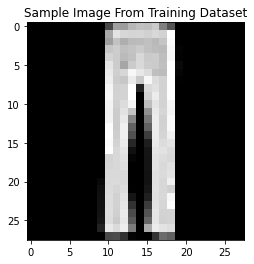

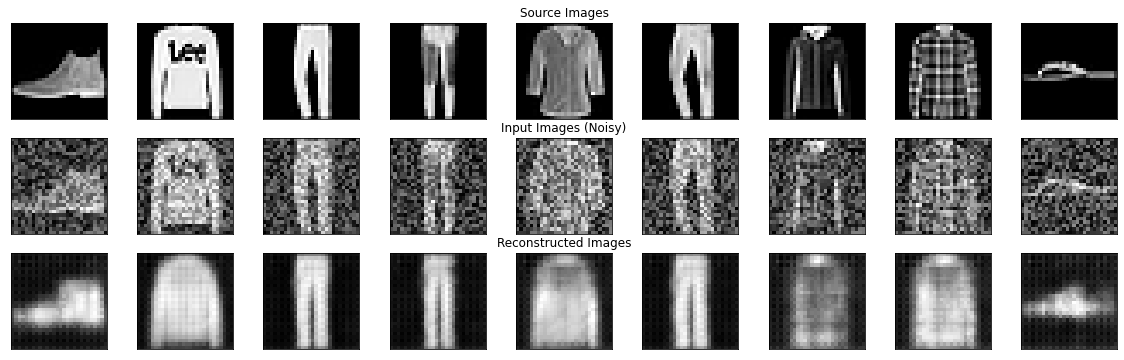

 10%|█         | 1/10 [00:20<03:02, 20.26s/it]

EPOCH 2/10 	 train loss 0.03634482994675636 	 test loss 0.037306685000658035


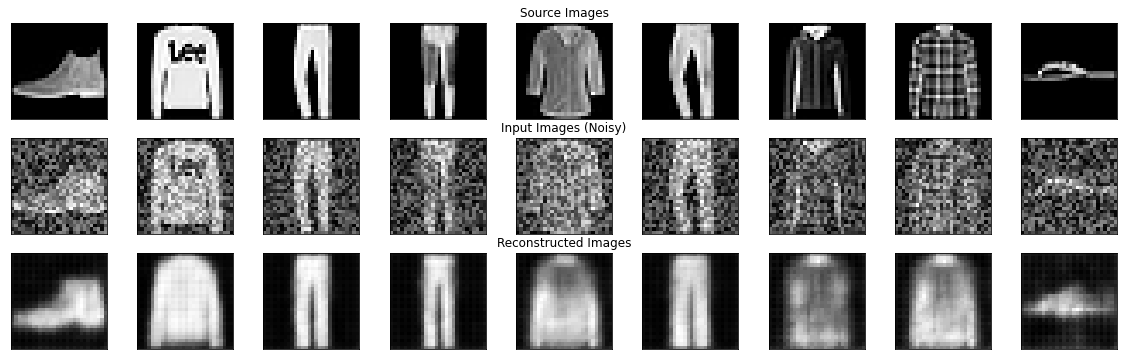

 20%|██        | 2/10 [00:38<02:32, 19.07s/it]

EPOCH 3/10 	 train loss 0.03538313880562782 	 test loss 0.03496618941426277


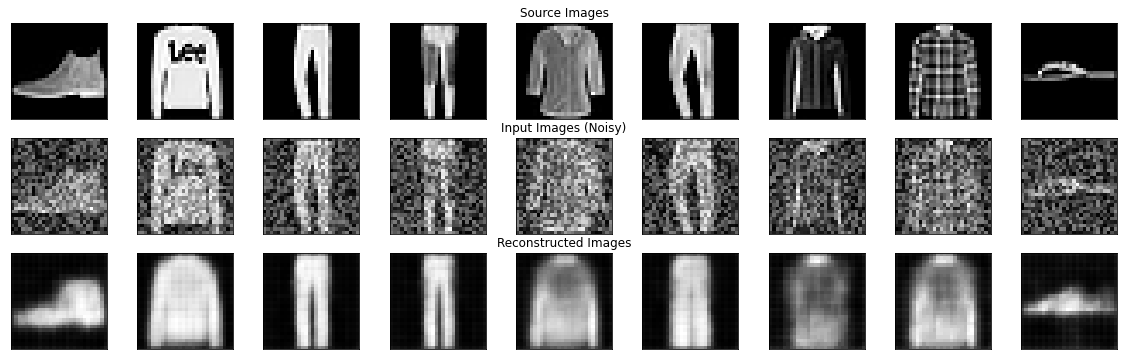

 30%|███       | 3/10 [00:56<02:10, 18.60s/it]

EPOCH 4/10 	 train loss 0.034912433475255966 	 test loss 0.03815031796693802


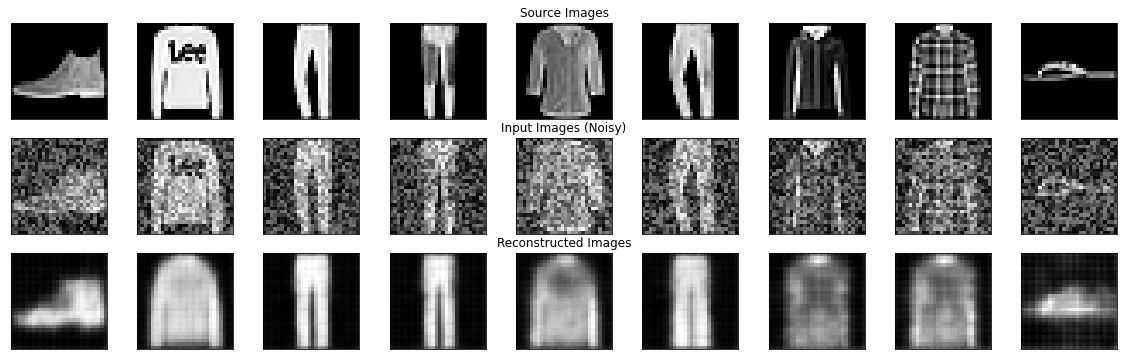

 40%|████      | 4/10 [01:14<01:51, 18.52s/it]

EPOCH 5/10 	 train loss 0.03437826409935951 	 test loss 0.03533253073692322


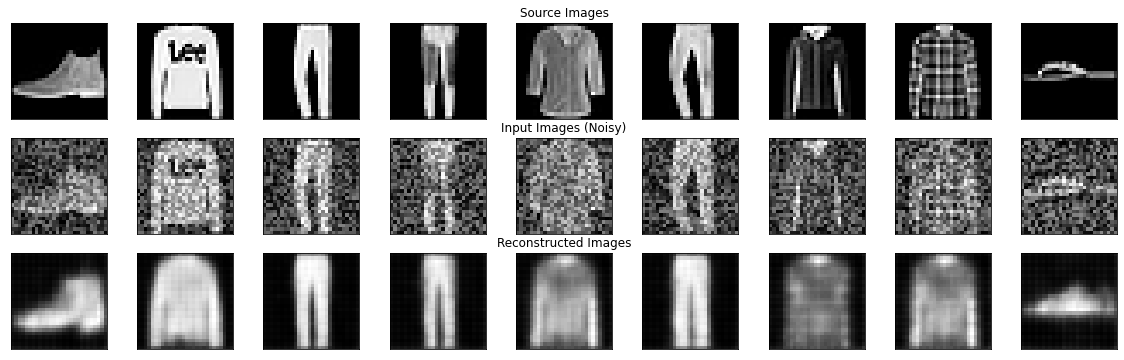

 50%|█████     | 5/10 [01:35<01:35, 19.11s/it]

EPOCH 6/10 	 train loss 0.03394288197159767 	 test loss 0.03543787822127342


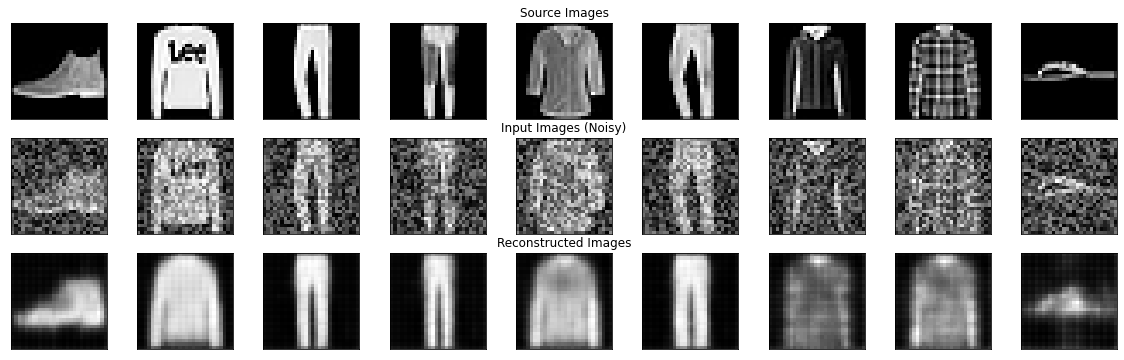

 60%|██████    | 6/10 [01:56<01:19, 19.98s/it]

EPOCH 7/10 	 train loss 0.03372744843363762 	 test loss 0.03484179452061653


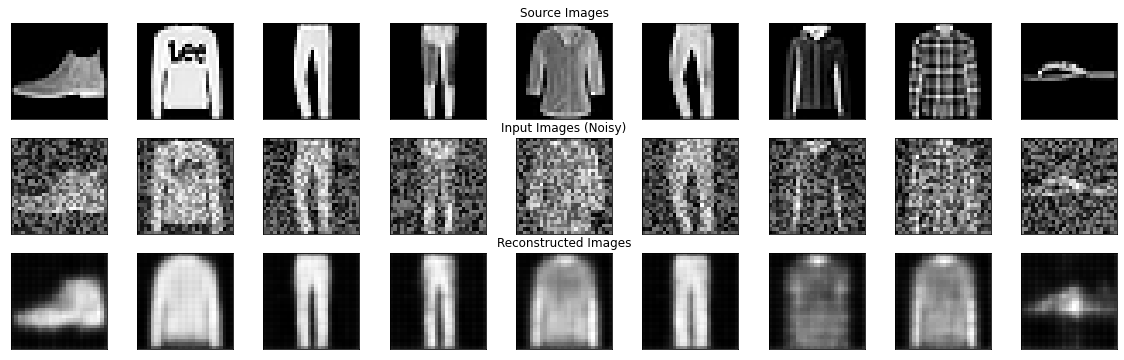

 70%|███████   | 7/10 [02:23<01:06, 22.04s/it]

EPOCH 8/10 	 train loss 0.03360321372747421 	 test loss 0.034871332347393036


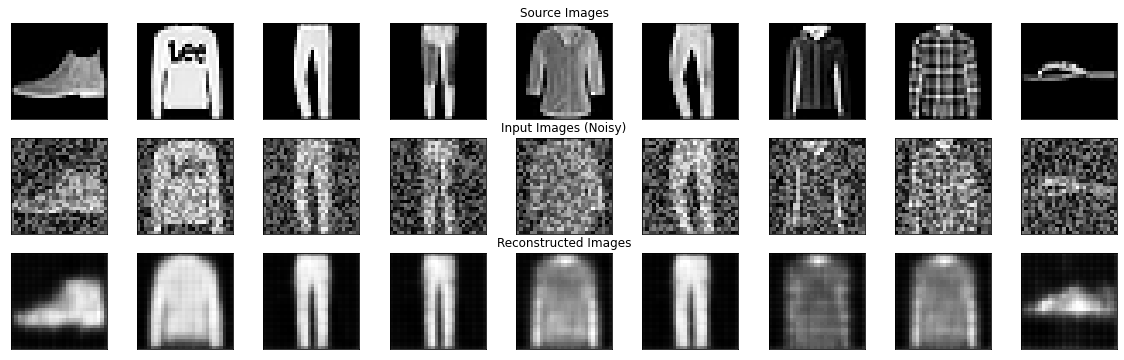

 80%|████████  | 8/10 [02:48<00:46, 23.15s/it]

EPOCH 9/10 	 train loss 0.03345171734690666 	 test loss 0.0367702916264534


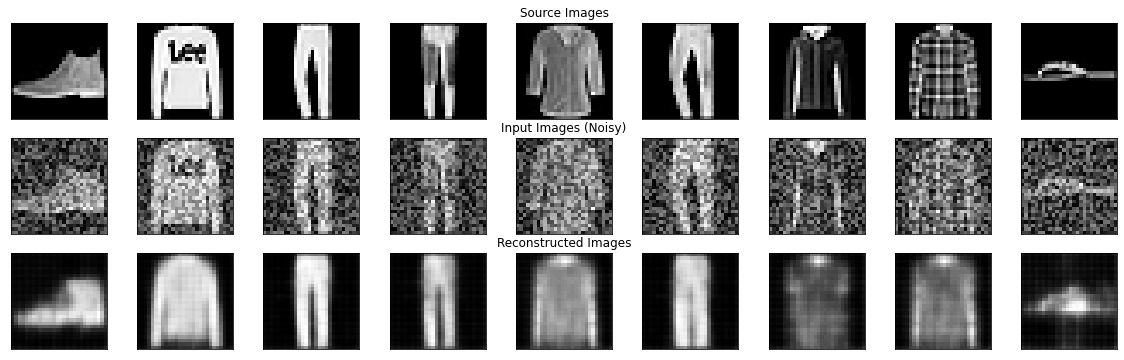

 90%|█████████ | 9/10 [03:13<00:23, 23.77s/it]

EPOCH 10/10 	 train loss 0.033347707241773605 	 test loss 0.0346054844558239


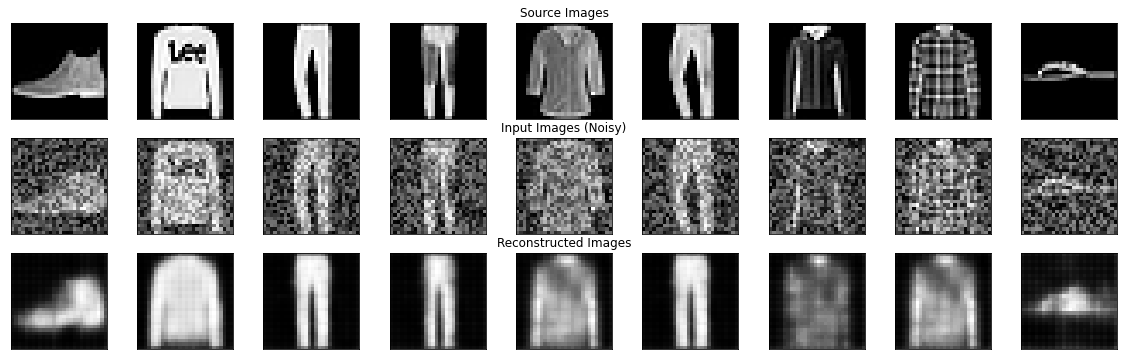

100%|██████████| 10/10 [03:38<00:00, 21.81s/it]
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: Agent Starting Run: bh2xinf3 with config:
	dropout: 0.2
	epochs: 10
	fc_layer_size: 36864
	optimizer: adam


/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: can't find '__main__' module in ''


wandb: Agent Starting Run: p4jcu5be with config:
	dropout: 0.2
	epochs: 10
	fc_layer_size: 36864
	optimizer: sgd


/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: can't find '__main__' module in ''


wandb: Agent Starting Run: qz6abqrc with config:
	dropout: 0.2
	epochs: 10
	fc_layer_size: 256
	optimizer: adam


/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: can't find '__main__' module in ''


wandb: Agent Starting Run: dr7zorfa with config:
	dropout: 0.2
	epochs: 10
	fc_layer_size: 256
	optimizer: sgd


/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: can't find '__main__' module in ''


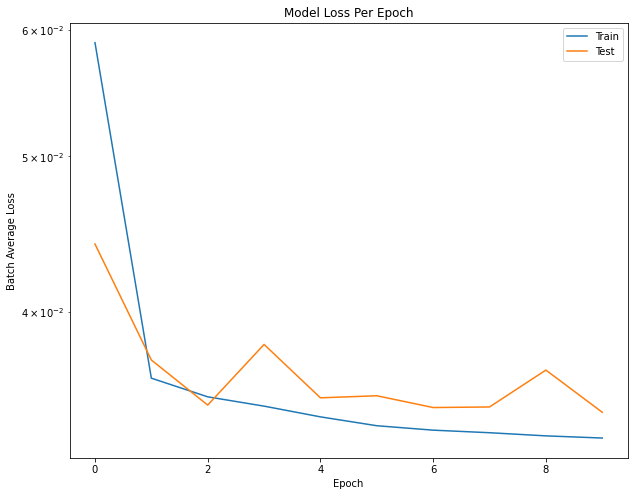

/usr/local/lib/python3.8/site-packages/wandb/wandb_torch.py:222: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if flat.shape == torch.Size([0]):
/usr/local/lib/python3.8/site-packages/wandb/wandb_torch.py:225: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  tmin = flat.min().item()
/usr/local/lib/python3.8/site-packages/wandb/wandb_torch.py:226: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means th

train_loss,0.03335
mse_loss,0.03335
cat_loss,0.03335
test_loss,0.03461
epoch,9
_runtime,252
_timestamp,1628272315
_step,10


train_loss,█▂▂▁▁▁▁▁▁▁
mse_loss,█▂▂▁▁▁▁▁▁▁
cat_loss,█▂▂▁▁▁▁▁▁▁
test_loss,█▃▁▄▂▂▁▁▃▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▂▃▃▄▅▆▆▇█
_timestamp,▁▂▂▃▃▄▅▆▆▇█
_step,▁▂▂▃▄▅▅▆▇▇█


100%|██████████| 10000/10000 [00:06<00:00, 1569.58it/s]


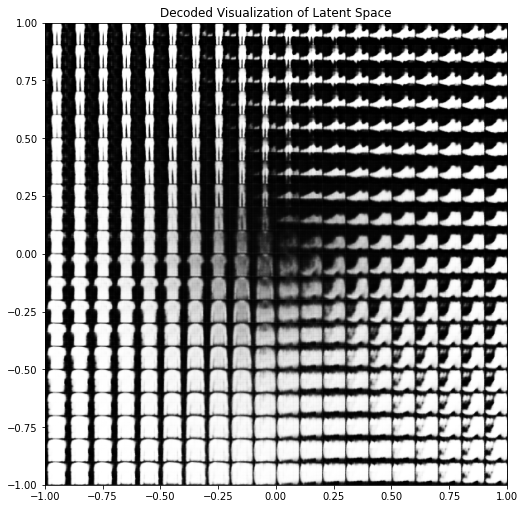

In [10]:
ae = DenoisingAutoencoder(config, dataset, dataset_path, loss_fn, optim_fn)


ae.plot_latent_images(r0=(-1, 1), r1=(-1, 1))
latent_pop_df = ae.gen_latent_pop(samp_size=latent_samp_size)
ae.plot_latent_topology(latent_pop_df)